In [202]:
import os
import gc
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
import lightgbm as lgb
from numpy import sort
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [203]:
train = pd.read_csv('/home/altieris/datascience/data/santander-customer-transaction-prediction/train.csv')
test = pd.read_csv('/home/altieris/datascience/data/santander-customer-transaction-prediction/test.csv')

print("Train: ",train.shape)
print("Test: ", test.shape)

Train:  (200000, 202)
Test:  (200000, 201)


In [204]:
cols=["target","ID_code"]

# drop_from_shap=['var_185', 'var_181', 'var_182', 'var_183', 'var_14', 'var_41',
#        'var_98', 'var_103', 'var_189', 'var_10', 'var_7', 'var_64',
#        'var_65', 'var_84', 'var_73', 'var_79', 'var_96', 'var_19',
#        'var_17', 'var_160', 'var_143', 'var_46', 'var_153', 'var_39',
#        'var_38', 'var_37', 'var_158', 'var_136', 'var_161', 'var_42',
#        'var_129', 'var_30', 'var_29', 'var_126', 'var_124', 'var_27',
#        'var_117', 'var_59', 'var_100','var_168', 'var_3', 'var_8', 'var_74', 'var_72', 'var_178',
#        'var_54', 'var_171', 'var_50', 'var_152', 'var_55', 'var_140',
#        'var_138', 'var_193', 'var_156', 'var_113', 'var_63', 'var_15',
#        'var_60', 'var_69', 'var_159', 'var_47', 'var_61', 'var_176',
#        'var_68', 'var_16', 'var_57', 'var_101', 'var_25', 'var_120','var_194', 'var_11', 'var_45', 'var_196', 'var_83', 'var_20',
#        'var_77', 'var_134', 'var_82', 'var_102', 'var_97', 'var_187',
#        'var_142', 'var_88', 'var_62', 'var_4']

In [108]:
# test = test.drop(drop_from_shap,axis=1)
# train = train.drop(drop_from_shap,axis=1)

In [205]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


We have a class imbalance problem with more records for class '0' than class '1' .... I tried SMOTE over sampling before but didn't seem to help...

### Permutation Importance

In [206]:
target = train.pop('target')
train_ids = train.pop('ID_code')
test_ids = test.pop('ID_code')
len_train = len(train)

The values towards the top are the most important features, and those towards the bottom matter least.

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

You'll occasionally see negative values for permutation importances. In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

In our case, the top 10 most important feature are var_81, var_53, var_139, var_179, var_174, var_40, var_26, var_13, var_24 and var_109. But, Still all the features seems to have value importance close to zero.

## Computing new features

In [207]:
#Merge test and train
merged = pd.concat([train, test])
#Saving the list of original features in a new list `original_features`.
original_features = merged.columns
merged.shape

(400000, 200)

In [208]:
%%time
idx = features = merged.columns.values[0:123]
for df in [merged]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

CPU times: user 10.7 s, sys: 5.51 s, total: 16.2 s
Wall time: 5.95 s


In [209]:
#Getting the list of names of the added features.
new_features = set(merged.columns) - set(original_features)

In [210]:
print("Total number of features: ",merged.shape[1])

Total number of features:  208


In [211]:
train = merged.iloc[:len_train]
X = train
train.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,12.7803,-1.0914,910.7792,-21.4494,43.1127,7.404709,9.266565,0.312327,1.810117,6.7602
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,18.3560,1.9518,854.8892,-47.3797,40.5632,6.950319,11.064601,-0.425218,4.994498,7.0433
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,14.7222,0.3965,813.5915,-22.4038,28.7632,6.614565,8.680910,-0.431941,0.737118,6.3577
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,17.9697,-8.9996,786.7067,-35.1659,38.1015,6.395989,9.858251,-0.818993,3.908457,6.8202
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,17.9974,-8.8104,772.3701,-65.4863,41.1037,6.279432,12.619397,-1.687160,9.763433,6.9860


In [212]:
test = merged.iloc[len_train:]
test.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,...,15.4722,-8.7197,963.1183,-31.9891,42.0248,7.830230,10.124670,-0.104436,2.487471,7.7798
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,...,19.1293,-20.9760,780.2476,-41.1924,35.6020,6.343476,9.762495,-0.797052,4.776168,6.0196
2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,...,19.8956,-23.1794,898.6623,-34.3488,37.8664,7.306198,10.171550,-0.381656,2.789642,8.0667
3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,...,13.0168,-4.2108,913.0137,-21.4797,40.3383,7.422876,8.532997,0.065783,2.467721,6.9174
4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,...,13.9260,-9.1846,965.5416,-15.6961,45.5510,7.849932,9.815783,0.847870,3.104922,6.8595


In [213]:
del merged
gc.collect()

83

## LGBM with new features

In [230]:
#original from kaggle
# params_tuned = {
#     'bagging_freq': 5,
#     'bagging_fraction': 0.4,
#     'boost_from_average':'false',
#     'boost': 'gbdt',
#     'feature_fraction': 0.05,
#     'learning_rate': 0.01,
#     'max_depth': -1,  
#     'metric':'auc',
#     'min_data_in_leaf': 80,
#     'min_sum_hessian_in_leaf': 10.0,
#     'num_leaves': 13,
#     'num_threads': 8,
#     'tree_learner': 'serial',
#     'objective': 'binary', 
#     'verbosity': 1
# }


params_tuned = {
    'objective': 'binary', 
    'boost': 'gbdt',
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'random_state': 42,
    'feature_fraction': 0.05,
    'learning_rate': 0.009,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 8.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    
    'verbosity': 1
}


In [231]:
%%time
X_test = test.values.astype(float)
y_pred_lgb = np.zeros(len(X_test))
features = [c for c in X.columns]
oof = np.zeros(len(train))
fold_n = 5
cv = fold_n
    
folds = StratifiedKFold(n_splits=fold_n, random_state=10, shuffle=True)

for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(params_tuned,train_data,num_boost_round=100000, valid_sets = [train_data, valid_data],verbose_eval=1000,early_stopping_rounds = 3000)
    oof[valid_index] = lgb_model.predict(X.iloc[valid_index][features], num_iteration=lgb_model.best_iteration)
    
    feature_importance_df = pd.DataFrame()
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = lgb_model.feature_importance()
    fold_importance_df["fold"] = fold_n + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    y_pred_lgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)/cv

print("CV SCORE: {:<8.5f}".format(roc_auc_score(y, oof)))

Fold 0 started at Mon Mar 11 00:40:50 2019
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.901673	valid_1's auc: 0.879154
[2000]	training's auc: 0.912411	valid_1's auc: 0.886167
[3000]	training's auc: 0.920258	valid_1's auc: 0.890597
[4000]	training's auc: 0.926208	valid_1's auc: 0.893313
[5000]	training's auc: 0.931206	valid_1's auc: 0.894749
[6000]	training's auc: 0.935585	valid_1's auc: 0.895773
[7000]	training's auc: 0.939532	valid_1's auc: 0.896457
[8000]	training's auc: 0.943291	valid_1's auc: 0.896726
[9000]	training's auc: 0.946815	valid_1's auc: 0.896859
[10000]	training's auc: 0.950171	valid_1's auc: 0.896916
[11000]	training's auc: 0.953374	valid_1's auc: 0.896855
[12000]	training's auc: 0.956408	valid_1's auc: 0.89685
[13000]	training's auc: 0.959341	valid_1's auc: 0.896775
Early stopping, best iteration is:
[10075]	training's auc: 0.950411	valid_1's auc: 0.896932
Fold 1 started at Mon Mar 11 00:44:54 2019
Training until validation s

### Feature Importance

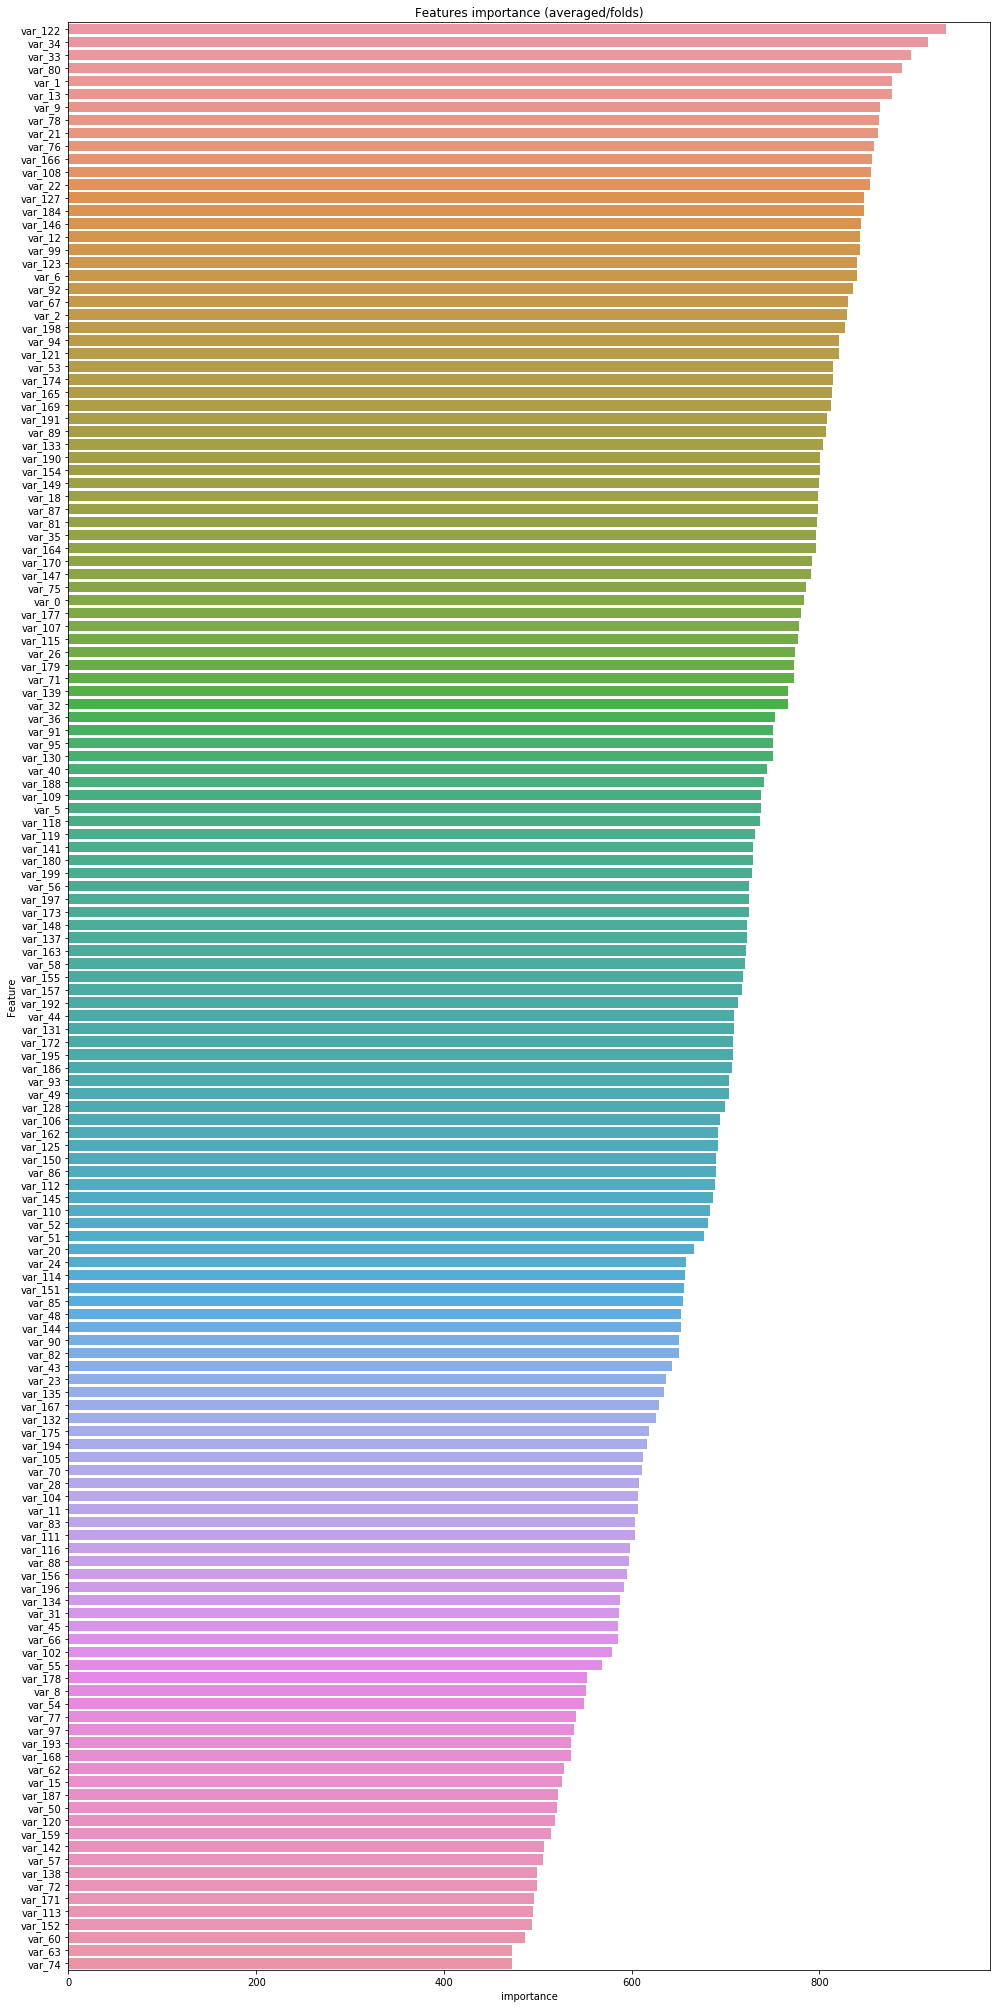

In [232]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

## Submission File

In [233]:
submission_lgb = pd.DataFrame({
        "ID_code": test_ids,
        "target": y_pred_lgb
    })
submission_lgb.to_csv('submission_lgb.csv', index=False)

## Credit:
Alexey Pronin's kernel (https://www.kaggle.com/graf10a/logistic-regression-with-new-features-feather) 

Gabriel Preda's kernel (https://www.kaggle.com/gpreda/santander-eda-and-prediction)

MohanRaj's kernel (https://www.kaggle.com/mytymohan/sct-prediction-eda-smote-lgbm)

JeremyLane's kernel (https://www.kaggle.com/lane203j/methods-and-common-mistakes-for-evaluating-models)